# Bicycle Accidents x Geo Data x Strava Exposure Merge

<small>

## Prerequisites for Publication-Ready Figures

This notebook uses **tueplots** with LaTeX rendering for high-quality, publication-ready visualizations. 

### Required Setup:

**1. Install TinyTeX (LaTeX distribution)**
```bash
# Option A: Via R (if you have R installed)
Rscript -e "tinytex::install_tinytex()"

# Option B: Direct installer (macOS)
curl -sL "https://yihui.org/tinytex/install-bin-unix.sh" | sh
```

**2. Install Required LaTeX Packages**
```bash
tlmgr update --self
tlmgr install type1cm cm-super underscore dvipng
```

**3. Add TinyTeX to PATH**
```bash
echo 'export PATH="$HOME/Library/TinyTeX/bin/universal-darwin:$PATH"' >> ~/.zshrc
source ~/.zshrc
```

**4. Verify Installation**
```bash
which latex && which dvipng
```

**Note:** After setup, restart VS Code or set PATH in the notebook as shown below.

</small>

In [ ]:
import sys
from pathlib import Path

# Ensure project root is importable when running from notebooks/
_project_root = Path.cwd().resolve()
if not (_project_root / "src").exists() and (_project_root.parent / "src").exists():
    _project_root = _project_root.parent
sys.path.insert(0, str(_project_root))

import os
os.environ['PATH'] = f"{os.path.expanduser('~/Library/TinyTeX/bin/universal-darwin')}:{os.environ['PATH']}"

import datetime as dt
import gc
import importlib

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Module imports
import src.accidents as accidents
import src.segments as segments
import src.strava_exposure as strava_exposure
import src.panels as panels
import src.nodes as nodes

# Reload project modules to get latest changes
for _m in (accidents, segments, strava_exposure, panels, nodes):
    importlib.reload(_m)

from src.accidents import (
    ACCIDENT_COLUMNS_EN,
    assign_accidents_to_nearest_segment,
    load_accidents_raw,
    prepare_accidents_bike_berlin,
    add_temporal_features,
    plot_accident_quality_overview,
)
from src.segments import load_segment_geometry, plot_segment_quality_overview
from src.strava_exposure import (
    build_exposure_panel_segment_year_month,
    column_stability_summary,
    categorize_strava_features,
    load_strava_berlin_data,
)
from src.panels import (
    aggregate_accidents_segment_year_month_rich,
    build_core_risk_panel,
    merge_exposure_and_accidents,
    sanity_check_merge,
)
from src.nodes import (
    assign_accidents_to_nearest_crossing,
    build_node_exposure_panel_from_segments,
    build_node_risk_panel,
    build_nodes_from_segment_endpoints,
    cluster_nodes_snap_grid,
    select_crossings_by_degree,
)

# Configuration constants
DATA_DIR = _project_root / "data"
MERGED_DIR = DATA_DIR / "merged"
CANONICAL_CRS = "EPSG:32633"
MAX_DISTANCE_M = 10
MAX_DISTANCE_M_NEREAST_CROSSING = 20
NODE_SNAP_TOLERANCE_M = 2
CROSSING_MIN_DEGREE = 3


def save_panel(df, filename, crs=None):
    """Save dataframe to parquet in merged directory."""
    MERGED_DIR.mkdir(parents=True, exist_ok=True)
    out_path = MERGED_DIR / filename
    
    if crs is not None:
        df = gpd.GeoDataFrame(df, geometry="geometry", crs=crs)
    
    df.to_parquet(out_path, index=False)
    print(f"Saved: {out_path}")
    return out_path

## Raw Datasets

### 1. Accident Data
- **Source**: [Destatis Unfallatlas](https://unfallatlas.statistikportal.de/)
- **Time Coverage**: 2019-2023 (**##### OR WE SHOULD TAKE RAW 2016-2024?####**)
- **Files**: CSV files from `data/accidents/` directory (Unfallorte_201[9-2023]_LinRef.csv)
- **Description**: Personal injury bicycle accidents in Berlin, Germany. The Accident Atlas contains accidents with personal injury only; material-damage-only accidents are excluded.
- **Key Fields**: Accident location coordinates, date, severity, accident type, street and other conditions
- **Limitation**: In accidents data we don't have specific datetime of accidents, only month, weekday and hour

### 2. Strava Exposure Data
- **Source**: [Urban Traffic Volume Dataset – Berlin (Strava), Zenodo](https://zenodo.org/records/15332147)
- **License**: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)
- **File**: `data/strava/berlin_data.parquet` (460.3 MB)
- **Time Coverage**: 2019-2023 (daily bicycle traffic volumes)
- **Description**: Daily bicycle traffic volumes aggregated from publicly shared Strava user data. Strava volumes are rounded aggregates of bike trips, with extreme outliers filtered per segment to focus on typical traffic conditions.
- **Auxiliary Features**: Built environment (speed limits, road types, lane counts), Points of Interest (shops, schools, transit stops), network connectivity metrics (degree, betweenness), temporal indicators (weekday, holidays, month), weather data (sunshine, precipitation, temperature), socioeconomic indicators, proxy motorized traffic metrics
- **Key Fields**: Segment identifiers, temporal aggregation (year/month), trip counts, activity metrics, environmental and infrastructure features

### 3. Road Network Geometry
- **Source**: [Urban Traffic Volume Dataset – Berlin (Strava), Zenodo](https://zenodo.org/records/15332147)
- **License**: [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)
- **File**: `data/strava/berlin_graph_geometry.parquet` (1.6 MB)
- **CRS**: EPSG:32633 (UTM Zone 33N)
- **Description**: Geospatial representation of Berlin's road network at street-segment level with geometric attributes
- **Key Fields**: Segment IDs, LineString geometries, segment properties

### Citation
For Strava Berlin dataset:
> Kaiser, S. K., Rodrigues, F., Azevedo Lima, C., & Kaack, L.H. (2025). Spatio-Temporal Graph Neural Network for Urban Spaces: Interpolating Citywide Traffic Volume. [published on arXiv].

In [2]:
accidents_raw = load_accidents_raw(csv_dir=DATA_DIR / "accidents")
segments_geometry_raw = load_segment_geometry(parquet_path = DATA_DIR / "strava" / "berlin_graph_geometry.parquet", canonical_crs=CANONICAL_CRS)
strava_berlin_data_raw = load_strava_berlin_data(parquet_path=DATA_DIR / "strava" / "berlin_data.parquet")

Reading berlin_graph_geometry.parquet locally from /Users/laysan/Desktop/University/data_literacy_/data_literacy/data/strava/berlin_graph_geometry.parquet
Reading berlin_data.parquet locally from /Users/laysan/Desktop/University/data_literacy_/data_literacy/data/strava/berlin_data.parquet


# Data preprocessing & Data Quality Check

## Accidents data

In [3]:
accidents_bike_berlin = prepare_accidents_bike_berlin(accidents_raw, column_map=ACCIDENT_COLUMNS_EN)
# Add temporal features (weekday_type and time_of_day)
accidents_bike_berlin = add_temporal_features(accidents_bike_berlin)

# Free big raw dataframe early to keep memory low for Strava aggregation
# del accidents_raw
# gc.collect()
print("Raw accidents shape:", accidents_raw.shape)
print(f"Filtered to bicycle accidents in Berlin -> shape: {accidents_bike_berlin.shape}")

Raw accidents shape: (1270730, 28)
Filtered to bicycle accidents in Berlin -> shape: (23537, 30)


/Users/laysan/Desktop/University/data_literacy_/data_literacy/src/accidents.py:498: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=3.5, w_pad=2.0)


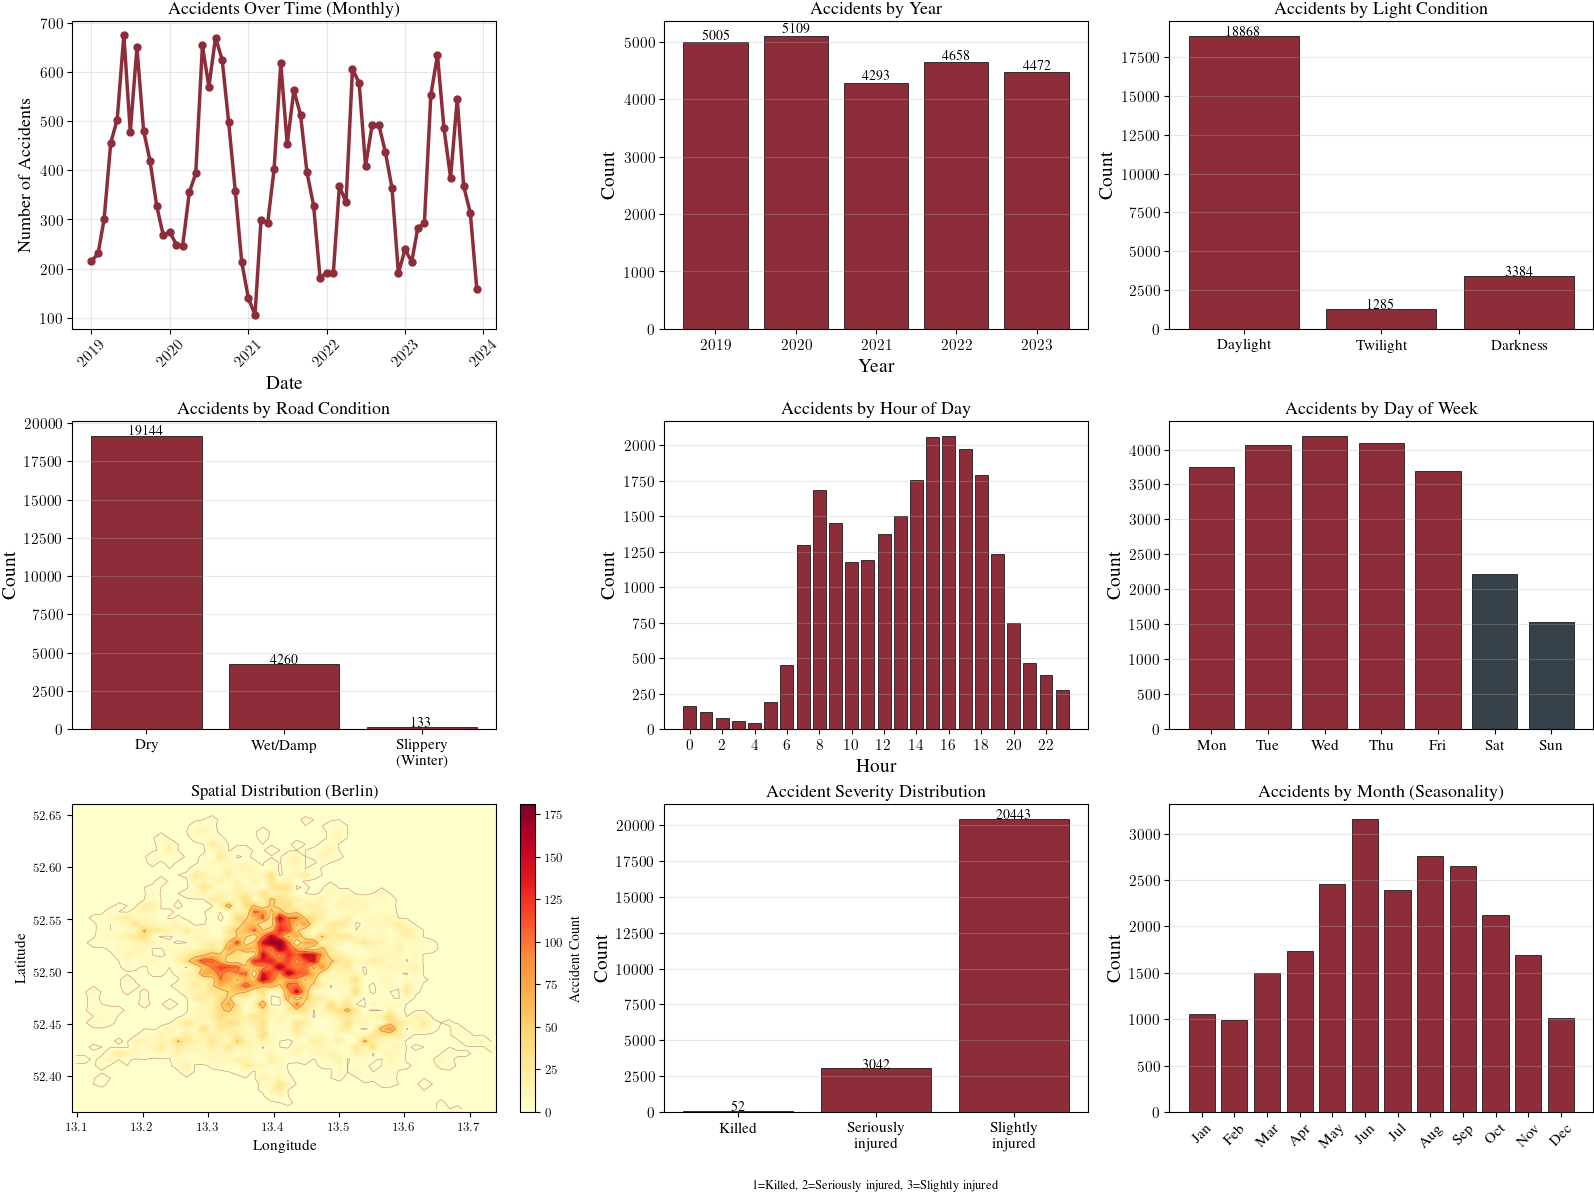


SUMMARY STATISTICS
Total accidents: 23,537
Date range: 2019 - 2023
Number of columns: 30
Duplicate check (accident_id_extended): ✓ PASS
  - Total non-null records: 18,532
  - Unique IDs: 18,532
  - Duplicates: 0
  - Missing IDs (NaN): 5,005

Temporal validity check: PASS
  - All records within expected range (2016-2024)

Missing values by column:
  plausibility_level: 19,065 (81.0%)
  oid: 14,772 (62.8%)
  object_id: 8,765 (37.2%)
  accident_id_extended: 5,005 (21.3%)

Total missing values: 47,607 (6.74% of all cells)


In [41]:
# Reload project modules to get latest changes
for _m in (accidents, segments, strava_exposure, panels, nodes):
    importlib.reload(_m)

from src.accidents import (
    plot_accident_quality_overview,
)

plot_accident_quality_overview(
    accidents_bike_berlin, 
    use_tueplots=True,
    save_path=None  # Set to "accident_overview_icml.pdf" to save
)

## Road Network Geometry

/Users/laysan/Desktop/University/data_literacy_/data_literacy/src/segments.py:287: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  reasonable_lengths = ((lengths >= 1) & (lengths <= 5000)).all()


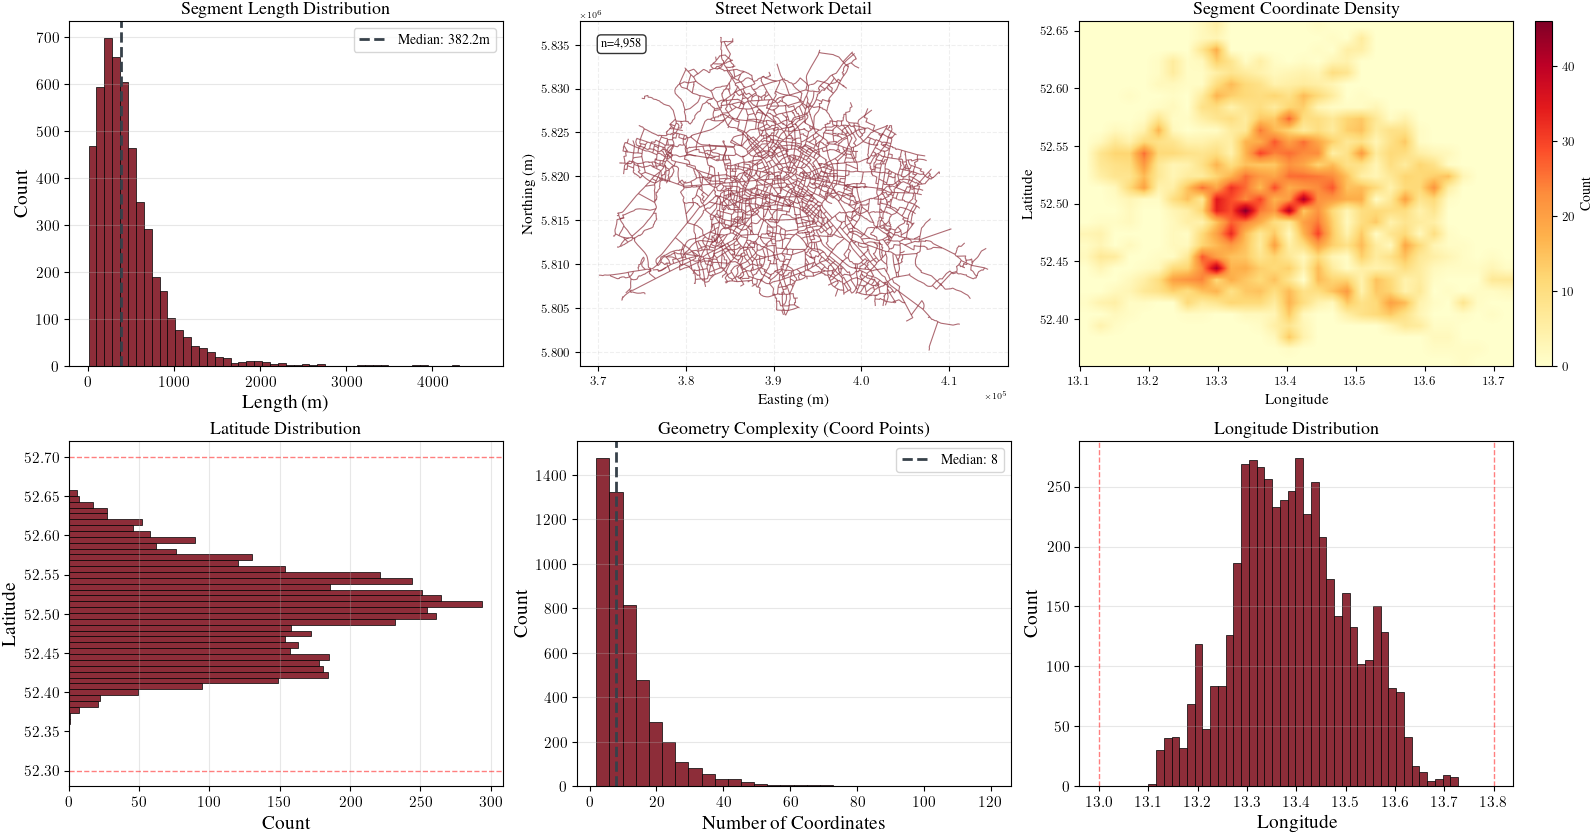


SUMMARY STATISTICS
Total segments: 4,958
Number of columns: 4

[PASS] Valid Geometry
  Description: All geometries are valid (invalid: 0)

[PASS] No Empty Geometry
  Description: No empty geometries (empty: 0)

[PASS] Coordinate Range (Berlin)
  Description: Coordinates within Berlin bounds (lat: 52.3-52.7, lon: 13.0-13.8)

[PASS] Unique Segment IDs
  Description: All segment IDs are unique (total: 4958, unique: 4958)

[PASS] Reasonable Lengths (1-5000m)
  Description: All lengths in valid range (too short: 0, too long: 0)

No missing values detected!


In [54]:
segment_geo_gdf = segments_geometry_raw.segments_gdf
segment_static = segments_geometry_raw.segment_static

plot_segment_quality_overview(segment_geo_gdf, use_tueplots=True)

## Strava Exposure Data

/Users/laysan/Desktop/University/data_literacy_/data_literacy/src/strava_exposure.py:456: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  total_records = len(strava_df)


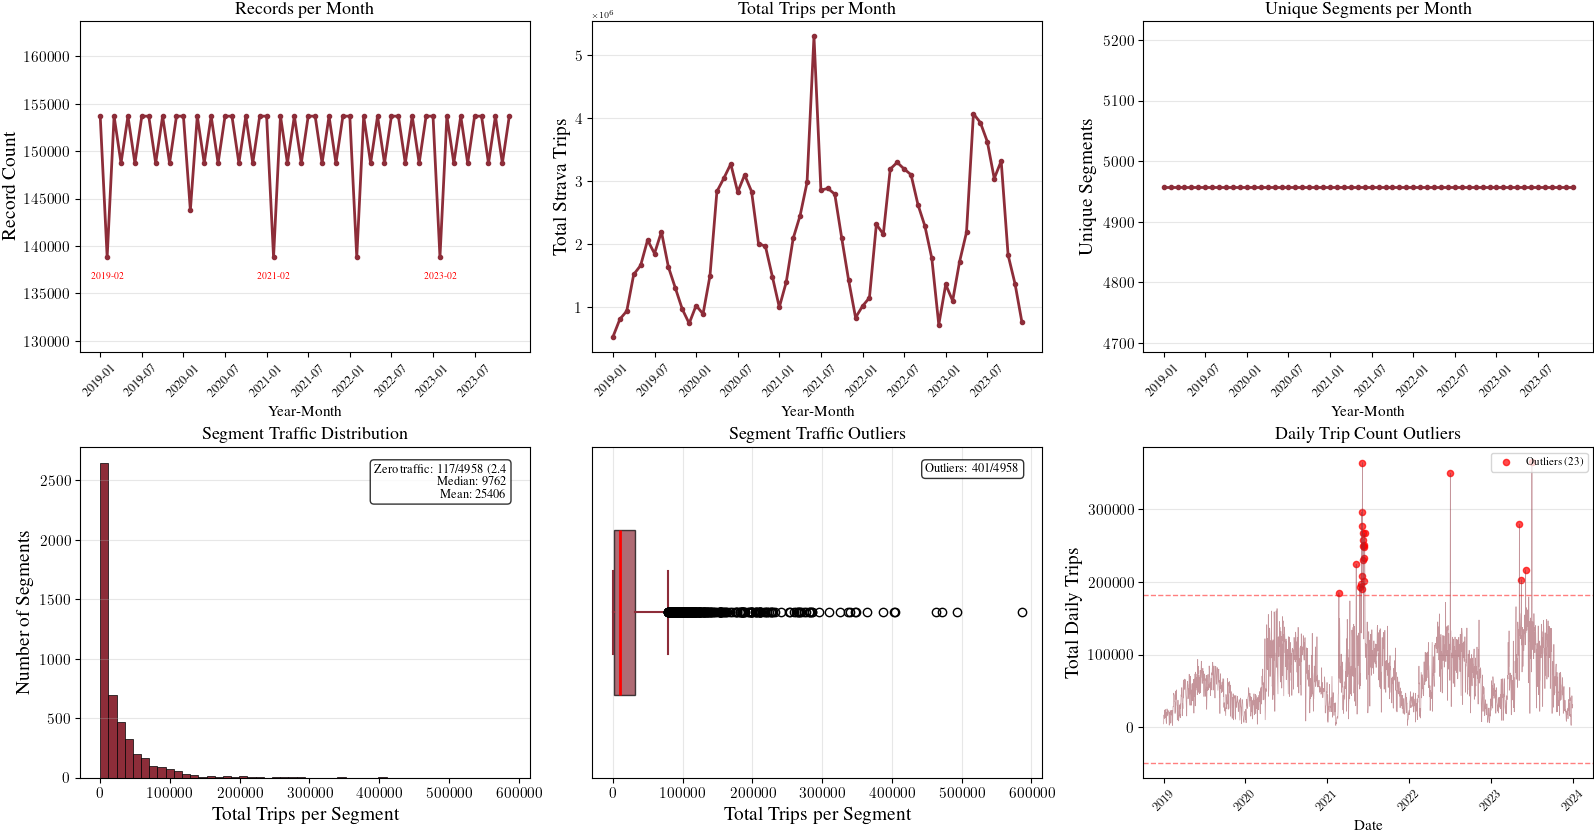


SUMMARY STATISTICS - STRAVA EXPOSURE DATA
Total records: 9,053,308
Number of columns: 137

----------------------------------------------------------------------
DATA QUALITY CHECKS
----------------------------------------------------------------------

[PASS] Temporal Coverage (2019-2023)
  Description: Date range: 2019-2023 (expected: 2019-2023)

[PASS] Required Columns Present
  Description: All required columns present

[PASS] No Duplicate Records (segment+date)
  Description: Unique records by segment+date

[PASS] Non-negative Trip Counts
  Description: All trip counts non-negative

[PASS] Segment Coverage Consistency
  Description: 4,958 unique segments, avg 1826 records/segment

[PASS] Segment Traffic Outliers (<10%)
  Description: 401 outliers (8.1% of 4958 segments)

[PASS] Temporal Coverage Gaps (<5%)
  Description: 0 missing days (0.0% of 1826 days)

[PASS] Key Columns Missing Data (<10%)
  Description: No missing data

[PASS] Daily Trip Count Outliers (<5%)
  Description: 

In [60]:
# Reload project modules to get latest changes
for _m in (accidents, segments, strava_exposure, panels, nodes):
    importlib.reload(_m)

from src.strava_exposure import plot_strava_quality_overview

plot_strava_quality_overview(strava_berlin_data_raw, use_tueplots=True)

### Feature Stability Analysis

Before aggregating Strava data by time periods, we need to understand which features are constant per segment (infrastructure, connectivity) and which vary over time (weather, traffic, socioeconomic indicators). This determines aggregation strategy:
- **Constant features**: Keep one value per segment (no aggregation needed)
- **Time-varying features**: Aggregate using appropriate functions (sum for counts, mean for continuous variables)

In [ ]:
# Analyze which columns are constant vs time-varying per segment
summary_df = column_stability_summary(strava_berlin_data_raw, group_col="counter_name")

print(f"\nTotal columns analyzed: {len(summary_df)}")
print(f"Constant columns (never vary within segment): {(summary_df['segments_varying'] == 0).sum()}")
print(f"Time-varying columns: {(summary_df['segments_varying'] > 0).sum()}")

# Show examples
print("\n" + "="*80)
print("CONSTANT FEATURES (top 10 - infrastructure/connectivity):")
print("="*80)
display(summary_df[summary_df['segments_varying'] == 0].head(10))

print("\n" + "="*80)
print("TIME-VARYING FEATURES (top 10 - traffic/weather/socioeconomic):")
print("="*80)
display(summary_df[summary_df['segments_varying'] > 0].head(10))

# Categorize features and compute category-level statistics
category_stats = categorize_strava_features(summary_df, strava_berlin_data_raw)

print("\n" + "="*80)
print("SUMMARY BY FEATURE CATEGORY:")
print("="*80)
display(category_stats)

# Datasets aggregation and merging

## Spatial Join: Accidents to Road Segments

Assigns each bicycle accident to its nearest road network segment using `assign_accidents_to_nearest_segment()`.

**Method:**
- Uses `gpd.sjoin_nearest()` with `max_distance_m=10` meters
- Accidents beyond this threshold remain unassigned
- When multiple segments are equidistant, keeps the first one after sorting by distance
- Ensures each accident is assigned to exactly one segment (duplicates removed by `acc_id`)

In [65]:
# Assign each accident to exactly one nearest segment (within max_distance)
joined_nearest_unique = assign_accidents_to_nearest_segment(
    accidents_bike_berlin,
    segment_geo_gdf,
    canonical_crs=CANONICAL_CRS,
    max_distance_m=MAX_DISTANCE_M,
)

print(f"Total accidents: {len(accidents_bike_berlin)}")
print(f"Total bike network Strava segments: {len(segment_geo_gdf)}")
print(f"Unique Strava segments in matched dataset: {joined_nearest_unique['counter_name'].nunique()}")
print(f"Accidents assigned to segments: {len(joined_nearest_unique)}")
print(f"Ratio of assigned accidents: {len(joined_nearest_unique) / len(accidents_bike_berlin):.2%}")

Total accidents: 23537
Total bike network Strava segments: 4958
Unique Strava segments in matched dataset: 3286
Accidents assigned to segments: 15398
Ratio of assigned accidents: 65.42%
